In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# img1 = cv.imread('Frame1.png')
# img2 = cv.imread('Frame2.png')
def detect_and_describe_features(img1, img2):
  gray_img_1= cv.cvtColor(img1,cv.COLOR_BGR2GRAY)
  gray_img_2= cv.cvtColor(img2,cv.COLOR_BGR2GRAY)

  sift = cv.SIFT_create()
  kp1, des1 = sift.detectAndCompute(gray_img_1,None)
  kp2, des2 = sift.detectAndCompute(gray_img_2,None)

  img1_kp=cv.drawKeypoints(img1, kp1, None)
  img2_kp=cv.drawKeypoints(img2, kp2, None)
  cv.imwrite('sift_keypoints_1.jpg',img1_kp)
  cv.imwrite('sift_keypoints_2.jpg',img2_kp)
  plt.imshow(img1_kp), plt.show()
  plt.imshow(img2_kp), plt.show()
  return kp1, kp2, des1, des2

In [ ]:
# create BFMatcher object
def match_features(img1, img2, des1, des2, kp1, kp2):
  bf = cv.BFMatcher(cv.NORM_L2)
  matches = bf.knnMatch(des1,des2, k=2)

  # Apply ratio test
  good_matches = []
  ratio = 0.4
  for m,n in matches:
    if m.distance < ratio*n.distance:
        good_matches.append([m])

  # cv2.drawMatchesKnn expects a list of lists as matches.
  matched_img = cv.drawMatchesKnn(img1,kp1,img2,kp2,good_matches,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
  plt.imshow(matched_img),plt.show()
  return good_matches

In [ ]:
# Resize images to the same dimensions if necessary
def center_overlay(img1, img2, kp1, kp2, good_matches):
  height, width = img1.shape[:2]
  img2_resized = cv.resize(img2, (width, height))

  # Blend images with transparency
  alpha = 0.5  # Transparency factor for blending
  overlay = cv.addWeighted(img1, alpha, img2_resized, 1 - alpha, 0)
  for m in good_matches:
      pt_a = tuple(map(int, kp1[m[0].queryIdx].pt))
      pt_b = tuple(map(int, kp2[m[0].trainIdx].pt))
      cv.line(overlay, pt_a, pt_b, (0, 255, 0),2)
  # Display the overlaid image
  plt.figure(figsize=(10, 10))
  plt.imshow(cv.cvtColor(overlay, cv.COLOR_BGR2RGB))
  plt.title("Centered Overlay Composite of Frame 1 and Frame 2")
  plt.axis("off")
  plt.show()

### Testing for images

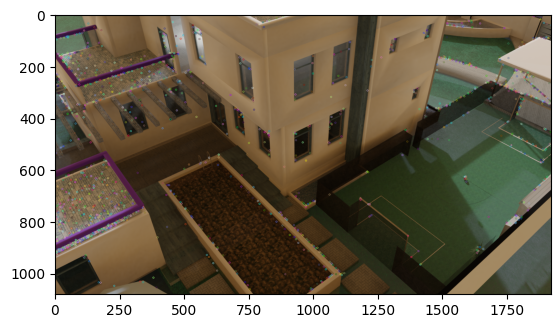

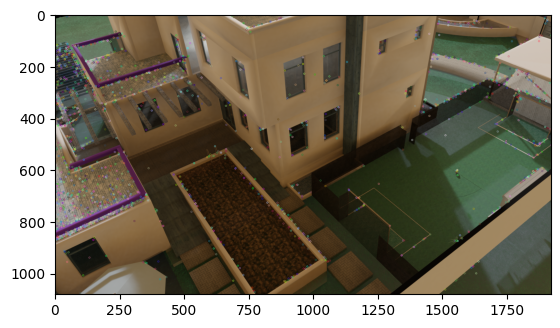

In [ ]:
img1 = cv.imread('Frame1.png')
img2 = cv.imread('Frame2.png')
kp1, kp2, des1, des2 = detect_and_describe_features(img1, img2)

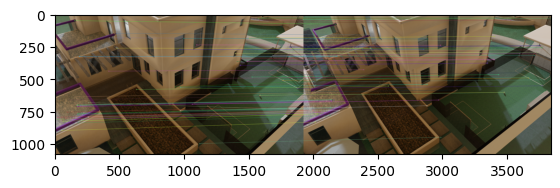

77


In [ ]:
good_matches = match_features(img1, img2, des1, des2, kp1, kp2)
print(len(good_matches))

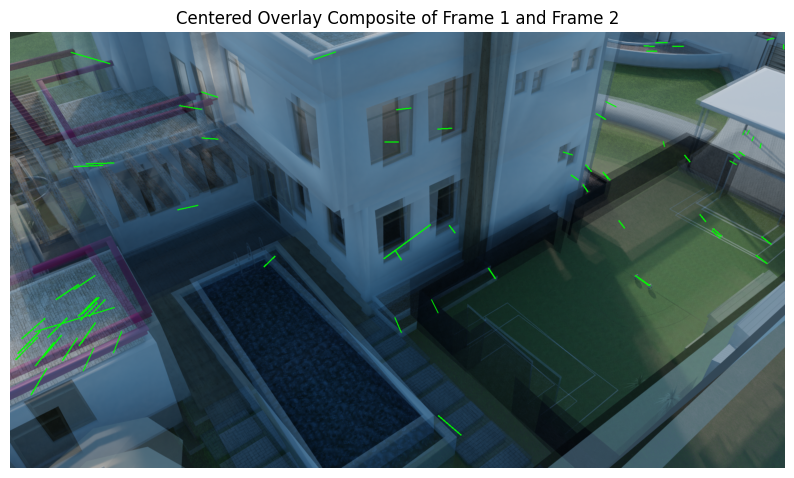

In [ ]:
center_overlay(img1, img2, kp1, kp2, good_matches)

###Estimating Fundamental Matrix using Matched Features

In [ ]:
def estimate_fundamental_matrix(kp1, kp2, good_matches):
  # Extract matched points
  pts1 = np.float32([kp1[m[0].queryIdx].pt for m in good_matches])
  pts2 = np.float32([kp2[m[0].trainIdx].pt for m in good_matches])
  # Estimate the fundamental matrix
  F_matched, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_8POINT)
  # F_matched, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)
  # # We select only inlier points based on the mask
  inliers_pts1 = pts1[mask.ravel() == 1]
  inliers_pts2 = pts2[mask.ravel() == 1]
  return F_matched

In [ ]:
F_matched = estimate_fundamental_matrix(kp1, kp2, good_matches)
print("Fundamental matrix from matched features:\n", F_matched)

Fundamental matrix from matched features:
 [[ 3.23185408e-07 -1.66433797e-05  4.35229840e-04]
 [ 1.77033297e-05 -1.49169715e-06 -3.01318629e-02]
 [-1.58861904e-03  2.88683561e-02  1.00000000e+00]]


###chatgpt suggestion which uses this formula:
First, calculate the essential matrix:
$$
E = [T]_{\text{cross}} \cdot R
$$

Then, compute the fundamental matrix:
$$
F = K_2^{-T} \cdot E \cdot K_1^{-1}
$$

In [ ]:
def estimate_fundamental_matrix_camera2(K1, K2, R, T):
  # Skew-symmetric matrix for T
  T_cross = np.array([
      [0, -T[2], T[1]],
      [T[2], 0, -T[0]],
      [-T[1], T[0], 0]
  ])
  # Essential matrix
  E = T_cross @ R

  # Compute F using K1 and K2
  F_camera2 = np.linalg.inv(K2).T @ E @ np.linalg.inv(K1)
  return F_camera2

In [ ]:
# Intrinsic matrices for camera
K1 = np.array([[1.600e+03, 0.000e+00, 9.595e+02],
              [0.000e+00, 1.600e+03, 5.395e+02],
              [0.000e+00, 0.000e+00, 1.000e+00]])

K2 = np.array([[1.49333333e+03, 0.00000000e+00, 9.78700000e+02],
              [0.00000000e+00, 1.49333333e+03, 5.20300000e+02],
              [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

R = np.array([[ 0.9971792 , -0.00348069, 0.07497863],
              [ 0.00362138, 0.99999203, -0.00174044],
              [-0.07497205, 0.00200697, 0.99718366]])

T = np.array([-1.98989457, 0.00265269, 0.20979508])
F_camera2 = estimate_fundamental_matrix_camera2(K1, K2, R, T)
print("Fundamental matrix from camera parameters:\n", F_camera2)

Fundamental matrix from camera parameters:
 [[-4.01210372e-10 -8.78019327e-08  4.97699667e-05]
 [ 2.51186447e-08  1.36583164e-09  1.31446124e-03]
 [-1.88336735e-05 -1.15844731e-03 -5.24927926e-02]]


### Checking Fundamental Matrixes accuracies based on meeting Epipolar Constraint formula:
  $$ \mathbf{x'}^T F \mathbf{x} = 0 $$

In [ ]:
def check_epipolar_constraint(good_matches, kp1, kp2, F):
  # Assuming `points1` and `points2` are the corresponding points from the two images,
  # and `F` is the fundamental matrix we want to evaluate.
  points1 = np.float32([kp1[m[0].queryIdx].pt for m in good_matches])
  points2 = np.float32([kp2[m[0].trainIdx].pt for m in good_matches])

  # Convert points to homogeneous coordinates by adding a column of ones
  points1_homogeneous = np.hstack([points1, np.ones((points1.shape[0], 1))])
  points2_homogeneous = np.hstack([points2, np.ones((points2.shape[0], 1))])

  # Compute the epipolar constraint for each point pair
  errors = []
  for i in range(points1_homogeneous.shape[0]):
      x1 = points1_homogeneous[i].reshape(3, 1)  # Column vector for point in image 1
      x2 = points2_homogeneous[i].reshape(3, 1)  # Column vector for point in image 2

      # Calculate x2.T * F * x1
      error = abs(x2.T @ F @ x1)[0][0]
      errors.append(error)

  # Calculate the average error
  average_error = np.mean(errors)
  return average_error

In [ ]:
average_error_matched = check_epipolar_constraint(good_matches, kp1, kp2, F_matched)
print("Average Epipolar Constraint Error for Estimated F based on matched features:", average_error_matched)
average_error_camera = check_epipolar_constraint(good_matches, kp1, kp2, F_camera2)
print("Average Epipolar Constraint Error for Estimated F based on camera parameters:", average_error_camera)

Average Epipolar Constraint Error for Estimated F based on matched features: 0.051244503830011424
Average Epipolar Constraint Error for Estimated F based on camera parameters: 0.006113334969635735


### Finding the correctly matched points that meet the epipolar constraint and illustrating these matches

In [ ]:
def filter_and_show_epipolar_matches(img1, img2, kp1, kp2, matches, F, threshold=0.01):
    """
    Filters matches based on the epipolar constraint x'TFx = 0 and visualizes them.

    Parameters:
        img1, img2: Input images.
        kp1, kp2: Keypoints from the two images.
        matches: List of DMatch objects (feature matches).
        F: Fundamental matrix.
        threshold: Tolerance threshold for the epipolar constraint.
    """
    # Convert the keypoints to point arrays
    points1 = np.float32([kp1[m[0].queryIdx].pt for m in matches])
    points2 = np.float32([kp2[m[0].trainIdx].pt for m in matches])

    # Convert points to homogeneous coordinates
    points1_homogeneous = np.hstack([points1, np.ones((points1.shape[0], 1))])
    points2_homogeneous = np.hstack([points2, np.ones((points2.shape[0], 1))])

    # Filter matches based on epipolar constraint
    correct_matches = []
    for i in range(points1_homogeneous.shape[0]):
        x1 = points1_homogeneous[i].reshape(3, 1)  # Point in image 1 (column vector)
        x2 = points2_homogeneous[i].reshape(3, 1)  # Point in image 2 (column vector)

        # Calculate the epipolar constraint value x' * F * x
        error = abs(x2.T @ F @ x1)[0][0]

        # Check if the match meets the epipolar constraint within the given threshold
        if error < threshold:
            correct_matches.append(matches[i])

    return correct_matches

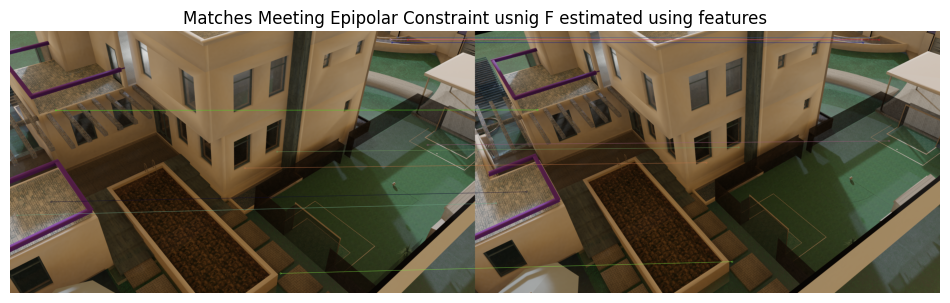

Number of matches that meet the epipolar constraint: 13


In [ ]:
correct_matches_F_matched = filter_and_show_epipolar_matches(img1, img2, kp1, kp2, good_matches, F_matched)
# Visualize the matches that meet the epipolar constraint
img_matches = cv.drawMatchesKnn(img1, kp1, img2, kp2, correct_matches_F_matched, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(12, 8))
plt.imshow(img_matches)
plt.title("Matches Meeting Epipolar Constraint usnig F estimated using features")
plt.axis("off")
plt.show()

print(f"Number of matches that meet the epipolar constraint: {len(correct_matches_F_matched)}")

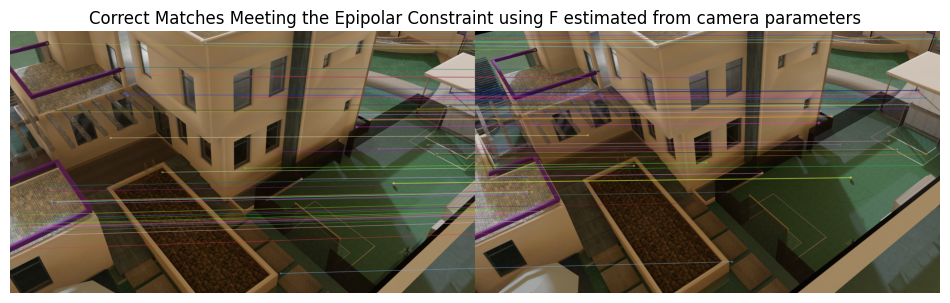

71


In [ ]:
correct_matches_F_camera2 = filter_and_show_epipolar_matches(img1, img2, kp1, kp2, good_matches, F_camera2)
img1_matches_2 = cv.drawMatchesKnn(img1, kp1, img2, kp2, correct_matches_F_camera2, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(12, 8))
plt.imshow(img1_matches_2)
plt.title("Correct Matches Meeting the Epipolar Constraint using F estimated from camera parameters")
plt.axis("off")
plt.show()
print(len(correct_matches_F_camera2))

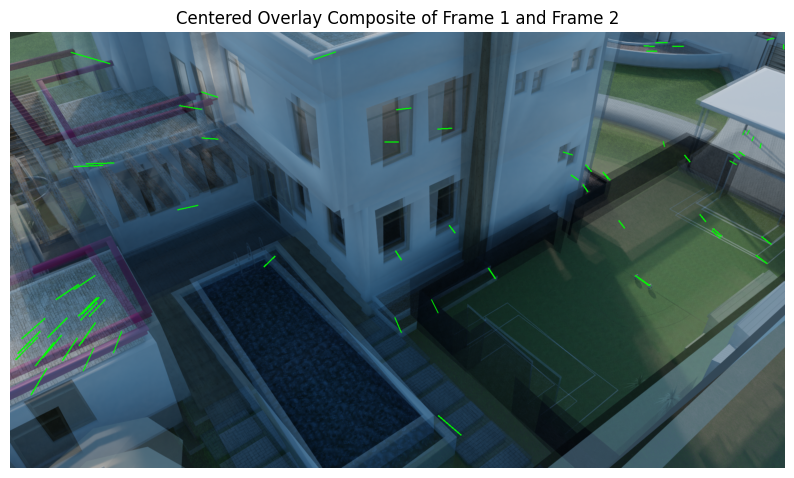

In [ ]:
center_overlay(img1, img2, kp1, kp2, correct_matches_F_camera2)

###Showing Epipolar Lines

In [ ]:
def show_epipolar_lines(img1, img2, kp1, kp2, matches, F):
    # Extract points from the good matches
    points1 = np.float32([kp1[m[0].queryIdx].pt for m in matches])
    points2 = np.float32([kp2[m[0].trainIdx].pt for m in matches])

    # Compute epilines in the second image for points in the first image and vice versa
    lines1 = cv.computeCorrespondEpilines(points2.reshape(-1, 1, 2), 2, F).reshape(-1, 3)
    lines2 = cv.computeCorrespondEpilines(points1.reshape(-1, 1, 2), 1, F).reshape(-1, 3)

    # Function to draw epipolar lines on an image
    def draw_lines(img, lines, points):
        img_with_lines = img.copy()
        for r, pt in zip(lines, points):
            color = tuple(np.random.randint(0, 255, 3).tolist())  # Random color for each line
            x0, y0 = map(int, [0, -r[2] / r[1]])
            x1, y1 = map(int, [img.shape[1], -(r[2] + r[0] * img.shape[1]) / r[1]])
            img_with_lines = cv.line(img_with_lines, (x0, y0), (x1, y1), color, 1)
            img_with_lines = cv.circle(img_with_lines, tuple(np.int32(pt)), 5, color, -1)
        return img_with_lines

    # Draw the lines on both images
    img1_with_lines = draw_lines(img1, lines1, points1)
    img2_with_lines = draw_lines(img2, lines2, points2)

    # Display the images with epipolar lines
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(cv.cvtColor(img1_with_lines, cv.COLOR_BGR2RGB))
    plt.title("Epipolar Lines in Image 1")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv.cvtColor(img2_with_lines, cv.COLOR_BGR2RGB))
    plt.title("Epipolar Lines in Image 2")
    plt.axis("off")

    plt.show()




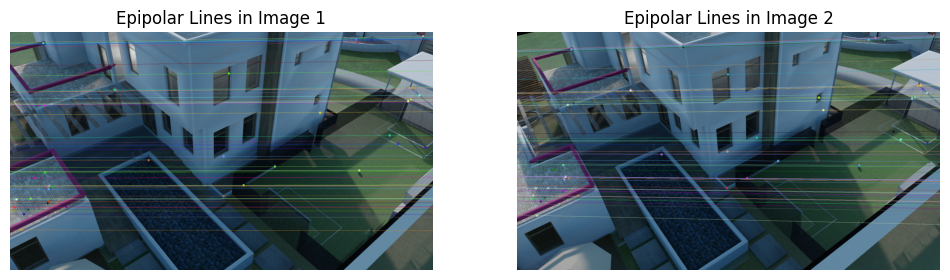

In [ ]:
show_epipolar_lines(img1, img2, kp1, kp2, correct_matches_F_camera2, F_camera2)

### Establish the disparity map between these frames

#### Applying Rectification

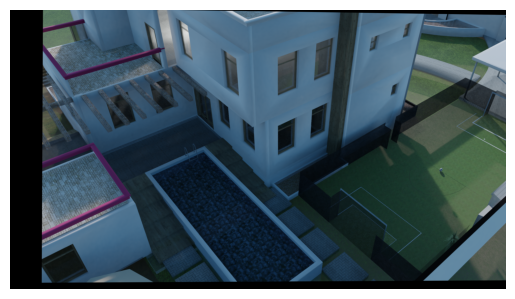

In [ ]:
# Applying rectification

# Intrinsic matrices
K1 = np.array([[1.600e+03, 0.000e+00, 9.595e+02],
               [0.000e+00, 1.600e+03, 5.395e+02],
               [0.000e+00, 0.000e+00, 1.000e+00]])

K2 = np.array([[1.49333333e+03, 0.00000000e+00, 9.78700000e+02],
               [0.00000000e+00, 1.49333333e+03, 5.20300000e+02],
               [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

R = np.array([[ 0.9971792 , -0.00348069, 0.07497863],
              [ 0.00362138, 0.99999203, -0.00174044],
              [-0.07497205, 0.00200697, 0.99718366]])

T = np.array([-1.98989457, 0.00265269, 0.20979508])

# Distortion coefficients
dist1 = np.zeros(5)
dist2 = np.zeros(5)

image_size = (img1.shape[1], img1.shape[0])

# Calculate the rectification maps
# Perform stereo rectification
R1, R2, P1, P2, Q, roi1, roi2 = cv.stereoRectify(K1, dist1, K2, dist2, image_size, R, T)
# Compute rectification maps for each camera
map1x, map1y = cv.initUndistortRectifyMap(K1, dist1, R1, P1, image_size, cv.CV_16SC2)
map2x, map2y = cv.initUndistortRectifyMap(K2, dist2, R2, P2, image_size, cv.CV_16SC2)


# Apply rectification maps to the images
rectified_img1 = cv.remap(img1, map1x, map1y, cv.INTER_LINEAR)
rectified_img2 = cv.remap(img2, map2x, map2y, cv.INTER_LINEAR)

# Display the rectified images
# Convert BGR images to RGB for displaying in matplotlib
rectified_img1_rgb = cv.cvtColor(rectified_img1, cv.COLOR_BGR2RGB)
rectified_img2_rgb = cv.cvtColor(rectified_img2, cv.COLOR_BGR2RGB)

# Display the rectified images using matplotlib
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
plt.imshow(rectified_img1_rgb)
# plt.title("Rectified Image 1")
plt.axis("off")

# plt.subplot(1, 2, 2)
# plt.imshow(rectified_img2_rgb)
# plt.title("Rectified Image 2")
# plt.axis("off")

plt.show()


#### Applying feature detection and description to rectified images

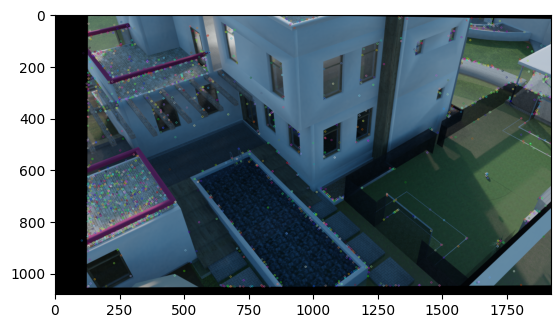

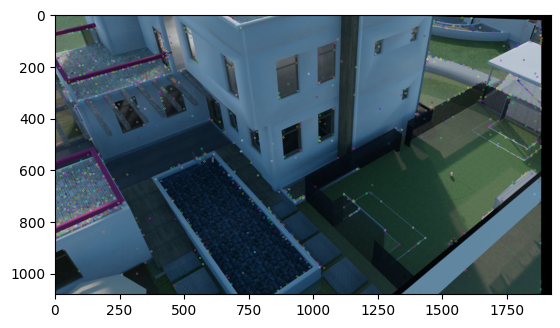

In [ ]:
kp1_prime, kp2_prime, des1_prime, des2_prime = detect_and_describe_features(rectified_img1_rgb, rectified_img2_rgb)

#### Finding matches between rectified images

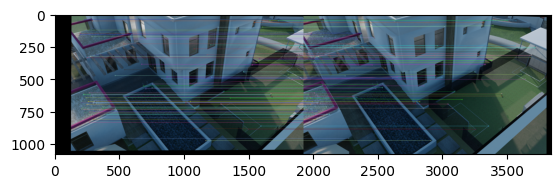

In [ ]:
matches_prime = match_features(rectified_img1_rgb, rectified_img2_rgb, des1_prime, des2_prime, kp1_prime, kp2_prime)

### Calculating area of pool and length of football field

In [ ]:
import math
baseline = -1/Q[3, 2]  # Assuming T is the translation vector between the cameras
focal_length = Q[2, 3] # Use the focal length from the intrinsic matrix


pool_box_frame_1 = ((753, 533),(540, 624),(1155, 974))
pool_box_frame_2 = ((613, 533),(392, 624),(1000, 968))

# print(baseline, focal_length)

(pool_x1, pool_y1), (pool_x2, pool_y2), (pool_x3, pool_y3) = pool_box_frame_1
(pool_x1_prime, pool_y1_prime), (pool_x2_prime, pool_y2_prime), (pool_x3_prime, pool_y3_prime) = pool_box_frame_2

cx, cy = -Q[0, 3], -Q[1, 3]

pool_depth1 = (baseline * focal_length) / (pool_x1 - pool_x1_prime)
pool_depth2 = (baseline * focal_length) / (pool_x2 - pool_x2_prime)
pool_depth3 = (baseline * focal_length) / (pool_x3 - pool_x3_prime)


pool_camera_X1 = (pool_x1 - cx) * pool_depth1 / focal_length
pool_camera_Y1 = (pool_y1 - cy) * pool_depth1 / focal_length
pool_camera_Z1 = pool_depth1
pool_camera_X2 = (pool_x2 - cx) * pool_depth2 / focal_length
pool_camera_Y2 = (pool_y2 - cy) * pool_depth2 / focal_length
pool_camera_Z2 = pool_depth2
pool_camera_X3 = (pool_x3 - cx) * pool_depth3 / focal_length
pool_camera_Y3 = (pool_y3 - cy) * pool_depth3 / focal_length
pool_camera_Z3 = pool_depth3


side1 = math.sqrt((pool_camera_X2 - pool_camera_X1)**2 + (pool_camera_Y2 - pool_camera_Y1)**2 + (pool_camera_Z2 - pool_camera_Z1)**2)
side2 = math.sqrt((pool_camera_X3 - pool_camera_X2)**2 + (pool_camera_Y3 - pool_camera_Y2)**2 + (pool_camera_Z3 - pool_camera_Z2)**2)
area = side1*side2
print(f"Estimated Pool Area: {area} square meters")

field_box_frame1 = ((1128, 712), (1743, 336))
field_box_frame2 = ((974, 712), (1634, 336))


field_x1, field_y1 = field_box_frame1[0]
field_x2, field_y2 = field_box_frame1[1]

field_x1_prime, field_y1_prime = field_box_frame2[0]
field_x2_prime, field_y2_prime = field_box_frame2[1]


cx, cy = -Q[0, 3], -Q[1, 3]

field_depth1 = (baseline * focal_length) / (field_x1 - field_x1_prime)
field_depth2 = (baseline * focal_length) / (field_x2 - field_x2_prime)

field_camera_X1 = (field_x1 - cx) * field_depth1 / focal_length
field_camera_Y1 = (field_y1 - cy) * field_depth1 / focal_length
field_camera_Z1 = field_depth1
field_camera_X2 = (field_x2 - cx) * field_depth2 / focal_length
field_camera_Y2 = (field_y2 - cy) * field_depth2 / focal_length
field_camera_Z2 = field_depth2
field_length = np.sqrt((field_camera_X2 - field_camera_X1)**2 + (field_camera_Y2 - field_camera_Y1)**2 + (field_camera_Z2 - field_camera_Z1)**2)
print(f"Estimated Touchline Length: {field_length:.2f} meters")

Estimated Pool Area: 29.45099606605373 square meters
Estimated Touchline Length: 15.26 meters


### Disparity Map

(-0.5, 1919.5, 1079.5, -0.5)

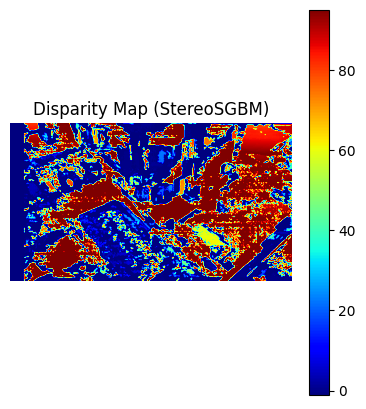

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Set parameters for StereoBM or StereoSGBM
# Note: The parameters here are examples and may need tuning for your specific setup

# For StereoBM (Basic Block Matching)


# # For StereoSGBM (Semi-Global Block Matching)

stereo_sgbm = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=16*6,  # Higher value if necessary
    blockSize=9,  # Smaller block sizes may help with detail
    P1=8*3*9**2,
    P2=32*3*9**2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32
)

# Compute disparity map using StereoBM or StereoSGBM
# Note: Both `rectified_img1` and `rectified_img2` should be grayscale images
# Convert rectified images to grayscale
# stereo_bm = cv.StereoBM_create(numDisparities=16*5, blockSize=15)
rectified_img1_gray = cv.cvtColor(rectified_img1, cv.COLOR_BGR2GRAY)
rectified_img2_gray = cv.cvtColor(rectified_img2, cv.COLOR_BGR2GRAY)

# Using StereoBM
# disparity_bm = stereo_bm.compute(rectified_img1_gray, rectified_img2_gray).astype(np.float32) / 16.0

# Using StereoSGBM
disparity_sgbm = stereo_sgbm.compute(rectified_img1_gray, rectified_img2_gray).astype(np.float32) / 16.0
# Display the disparity map
# plt.figure(figsize=(20, 10))

# # Display StereoBM disparity map
# plt.subplot(1, 2, 1)
# plt.imshow(disparity_bm, cmap='gray')
# plt.colorbar()
# plt.title('Disparity Map (StereoBM)')
# plt.axis('off')

# # Display StereoSGBM disparity map
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 2)
plt.imshow(disparity_sgbm, cmap='jet')
plt.colorbar()
plt.title('Disparity Map (StereoSGBM)')
plt.axis('off')

# plt.show()